In [1]:
#Importing required libraries for data cleanup on CSV files, and to create DataFrames

import pandas as pd
from pathlib import Path
import numpy as np
import csv
from datetime import datetime
import sqlalchemy
#pd.set_option('display.max_rows', 1000)

In [2]:
#Creating Dataframes from the CSV files

inlaw_df = pd.read_csv(Path("Updated_CSV/inlaw_csv"), infer_datetime_format=True, parse_dates=True, index_col='Date')
johnson_df = pd.read_csv(Path("Updated_CSV/johnson_csv"), infer_datetime_format=True, parse_dates=True, index_col='Date') 
johnson_ira_df = pd.read_csv(Path("Updated_CSV/johnson_ira_csv"), infer_datetime_format=True, parse_dates=True, index_col='Date')

In [3]:
#Changing Dates to datetime formats

inlaw_df['Expiration Date'] = pd.to_datetime(inlaw_df['Expiration Date'])
johnson_df['Expiration Date'] = pd.to_datetime(johnson_df['Expiration Date'])
johnson_ira_df['Expiration Date'] = pd.to_datetime(johnson_ira_df['Expiration Date'])

In [4]:
#Creating SQL Database w/ all dataframes

database_connection_string = 'sqlite:///portfolios.db'
engine = sqlalchemy.create_engine(database_connection_string)

In [5]:
#creating SQL database w/ dataframes

inlaw_df.to_sql('inlaw', engine, if_exists='replace')
johnson_df.to_sql('johnson', engine, if_exists='replace')
johnson_ira_df.to_sql('johnsonira', engine, if_exists='replace')

In [6]:
query = """
SELECT Value, Quantity, "Average Price", Commissions, Fees, "Strike Price"
FROM inlaw
WHERE Type = "Trade" AND "Instrument Type" != "Equity";
"""
inlaw_returns_df = pd.read_sql_query(query, con=engine)

In [7]:
def profit_per_trade(Value, Commissions, Fees):
    return (Value + Commissions + Fees)

profit_per_option_trade_df = profit_per_trade(inlaw_returns_df['Value'], inlaw_returns_df['Commissions'], inlaw_returns_df['Fees'])

In [8]:
profit_per_option_trade_df.cumsum()

0        47.858
1       556.988
2       106.118
3      -806.152
4       113.564
         ...   
345    5942.826
346    6139.674
347    6330.522
348    6902.152
349    7773.782
Length: 350, dtype: float64

<AxesSubplot:>

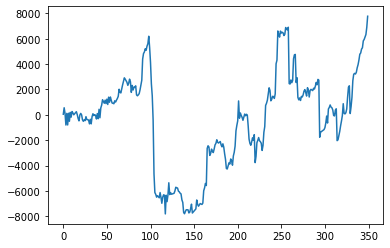

In [9]:
profit_per_option_trade_df.cumsum().plot()

In [10]:
query = """
SELECT *
FROM inlaw
WHERE Action = "SELL_TO_OPEN" 
OR Action = "SELL_TO_CLOSE";
"""
SELL_TO_OPEN_OR_CLOSE_df = pd.read_sql_query(query, con=engine)

In [11]:
query = """
SELECT *
FROM inlaw
WHERE Action = "BUY_TO_CLOSE" 
OR Action = "BUY_TO_OPEN";
"""
BUY_TO_OPEN_OR_CLOSE_df = pd.read_sql_query(query, con=engine)

In [12]:
query = """
SELECT *
FROM inlaw
WHERE "Call or Put" = "CALL";
"""
CALL_df = pd.read_sql_query(query, con=engine)

In [13]:
query = """
SELECT *
FROM inlaw
WHERE "Call or Put" = "PUT";
"""
PUT_df = pd.read_sql_query(query, con=engine)

In [14]:
query = """
SELECT *
FROM inlaw
WHERE "Instrument Type" = "Equity Option";
"""
equity_option_df = pd.read_sql_query(query, con=engine)

In [15]:
query = """
SELECT *
FROM inlaw
WHERE "Instrument Type" = "Future Option";
"""
future_option_df = pd.read_sql_query(query, con=engine)

In [16]:
query = """
SELECT *
FROM inlaw
WHERE "Instrument Type" = "Future Option" 
OR "Instrument Type" = "Equity Option";
"""
option_df = pd.read_sql_query(query, con=engine)
option_df.to_sql('option', engine, if_exists='replace')

In [17]:
query = """
SELECT *
FROM option
WHERE Action = "SELL_TO_OPEN" 
OR Action = "SELL_TO_CLOSE";
"""
sell_option_df = pd.read_sql_query(query, con=engine)

In [18]:
query = """
SELECT *
FROM inlaw
WHERE Action = "BUY_TO_OPEN" 
OR Action = "BUY_TO_CLOSE";
"""
buy_option_df = pd.read_sql_query(query, con=engine)

In [19]:
query = """
SELECT *
FROM inlaw
WHERE "Instrument Type" = "Equity";
"""
equity_df = pd.read_sql_query(query, con=engine)

In [20]:
profit_per_equity_trade_df = profit_per_trade(equity_df['Value'], equity_df['Commissions'], equity_df['Fees'])
profit_per_equity_trade_df.cumsum()

0      41717.688
1      83236.376
2     124754.064
3     166257.752
4     124932.672
5      84244.592
6      43554.512
7       2923.432
8     -37661.648
9     -78243.728
10           NaN
11           NaN
12           NaN
13   -117193.808
14   -125033.888
15   -131568.355
16   -131578.286
17   -132977.819
18   -133970.399
19   -134090.769
20   -135093.849
21   -136096.929
22   -137100.009
23   -146127.729
24   -147010.440
25   -148013.520
26   -150019.680
27   -151022.760
28   -152025.840
29   -153028.920
30   -153931.692
31   -154032.000
32   -154516.215
33   -156722.081
34   -167150.161
35   -169918.701
dtype: float64

In [21]:
query = """
SELECT "Order #",
    Sum(Value) AS Value
FROM inlaw
GROUP BY "Order #"
"""
order_sorted = pd.read_sql_query(query, con=engine)

In [22]:
order_sorted['Value'].describe()

count       277.000000
mean       1068.136823
std       28720.315307
min      -41264.000000
25%        -187.500000
50%          74.000000
75%         299.000000
max      457501.650000
Name: Value, dtype: float64

In [23]:
order_sorted['Value'].cumsum()

0      457501.65
1      458376.65
2      458951.65
3      459341.65
4      459453.65
         ...    
272    295742.40
273    295762.40
274    295312.40
275    295824.90
276    295873.90
Name: Value, Length: 277, dtype: float64

In [24]:
order_sorted['Value'].sum()

295873.9

<AxesSubplot:>

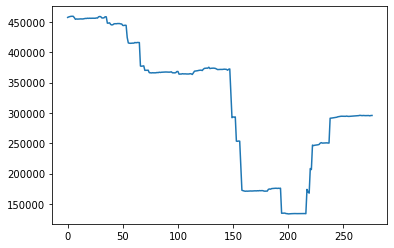

In [25]:
order_sorted['Value'].cumsum().plot()

In [26]:
query = """
SELECT "Underlying Symbol",
    Sum(Value) AS Value
FROM inlaw
GROUP BY "Underlying Symbol"
"""
ticker_sorted = pd.read_sql_query(query, con=engine)